# 127 量子ビットを使う（2023年春 Lab5）

  ```{note}
  このNotebookは、ibm_brisbane用にコードを改変しています。
  ```

これまでのChallengeが解けたとのこと、おめでとうございます！Dyanmic circuitをうまく使えることがわかりましたね。
ここまで来たご褒美として、127量子ビットデバイスの1つを使うことができます。


注意事項として、Challengeの完了でバッジを獲得するには、5つのLabのうち4つを終了している必要があります。このように決定した理由は、このLabが (a)技術的に困難であり、 (b)当社の最先端のハードウェアを使用することが分かっているためで、意図的にこのように決定しました。100量子ビットを超えるデバイスを一般に公開すると、ジョブの実行に大きな遅れが生じる可能性があるというのが実情です。Challengeの終了までにジョブを成功させることができない可能性もあります（そうでないことを祈りますが！）。そのようなことがないように、私たちは舞台裏でできる限りのことをしていますが、しかし、今年のChallengeは過去最高の参加者数を記録しています。親切に、何度も回路を提出し、キューを詰まらせないようにしてください。

まず、深呼吸してみましょう。では、始めましょう！

実際の物理的なデバイスを扱うには、それなりの困難が伴うことは、すでにお分かりいただけたと思います。
多数の量子ビットを使用する場合は、経路が長くなり、多くのエラーが発生しないようにする必要があるため、なおさらです。ここでは、ibm_sherbrookをデバイスとして使用します。

```{admonition} 解説
:class: tip
2023年末現在、誰でも無償利用可能の127量子ビットデバイスである、 [ibm_brisbane](https://quantum.ibm.com/services/resources?system=ibm_brisbane) を使います。デバイストポロジーは、ibm_sherbrookと同じです。
```

この課題では、127量子ビットの完全なエンタングル状態、いわゆるGHZ状態を賢い方法で準備してもらいます。

その後、エラー訂正の知識を127量子ビットのGHZ状態に適用し、54量子ビットのGHZ状態を作成するようガイドします。そのために、54量子ビットGHZ状態には偶数量子ビットを使用し、奇数量子ビットはスタビライザーとして使用することにします。

*注：奇数量子ビットと偶数量子ビットの使い方が違っても、同じレジスターを使うことにします。これは、特にDepthを手動で最適化する場合に、最初の127量子ビットのGHZ状態を簡単に作成できるようにするためです。*

```{admonition} 解説
:class: tip
偶数量子ビット（even numbered qubits）、奇数量子ビット（odd numbered qubits）という言葉を使っていますが、偶数番号の量子ビット、奇数番号の量子ビットの意味ではなく、下のセルで設定された量子ビット番号のことを意味しています。
```

In [1]:
# 必要な部品をインポートします
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

# レジスターを準備します
quantum_register = QuantumRegister(127)
classical_register = ClassicalRegister(127)

# 簡単のため、物理量子ビットを論理量子ビットに直接マッピングします
initial_layout = [  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                   20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                   40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                   60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                   80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,
                  120,121,122,123,124,125,126]
# 「偶数」量子ビットは54量子ビットのGHZ状態に使われます。名前はqhz_qubitです：
ghz_qubits = [0,2,4,6,8,10,12,18,20,22,24,26,28,30,32,37,39,
              41,43,45,47,49,51,56,58,60,62,64,66,68,70,75,77,79,
              81,83,85,87,89,94,96,98,100,102,104,106,108,114,116,118,120,122,124,126,]
# 「奇数」量子ビットはスタビライザーとして使われます。名前はstabilizer_qubitsです：
stabilizer_qubits = [1,3,5,7,9,11,14,15,16,17,19,21,23,25,27,29,31,33,34,35,36,38,
                     40,42,44,46,48,50,52,53,54,55,57,59,61,63,65,67,69,71,72,73,74,76,78,
                     80,82,84,86,88,90,91,92,93,95,97,99,101,103,105,107,109,110,111,112,115,117,119,121,123,125,]

## Step 1: 大きなGHZ状態を作る

多くの量子アルゴリズムでは、複数の量子ビットを互いにエンタングルする必要があります。
アルゴリズムでよく使われる状態の1つに、一般化されたGHZ状態があり、 $(\alpha |00...0\rangle + \beta |11...1\rangle)$ このとき $\alpha = \beta$ という状態です。

GHZ状態は完全にエンタングルされており、任意の数の量子ビットに一般化することができます。ここでは、これを用いて127量子ビットのGHZ状態を作ることにします！
**何個の量子ビットによるGHZ状態であっても、GHZ状態は測定されると、すべての量子ビットが0か1かのどちらかになっています。**

ここでのchallengeは、127個の量子ビットを理論的にエンタングルさせることではなく、 _実際のデバイス上で_ エンタングルさせることです。つまり、デバイスのレイアウトを考慮する必要があります（例えば、互いに直接接続されていない量子ビットの間でCXゲートを使用しないなど）。また、ノイズを減らすために、回路の深さをできるだけ小さくするようにする必要があります。

### Exercise 1

````{admonition} GHZ状態の生成
アダマールゲートとCNOTゲートだけを使って、127量子ビットのデバイス `ibm_sherbrook` にGHZ状態を生成してください。できるだけ回路のDepthが小さくなるようにしてみてください。

```{hint}
すべての量子ビットが互いに接続されている理想的なデバイスに対して、（最小のDepthで）どのように行うかを最初に考えることが助けになることがあります。
```

```python
def generate_ghz127():
    qc = QuantumCircuit(quantum_register, classical_register)

    ####### your code goes here #######

    return qc


ghz_circuit = generate_ghz127()
print(ghz_circuit.depth())
```
````

### Exercise 1 - 解答例

In [3]:
## 解答例
def generate_ghz127():
    qc = QuantumCircuit(quantum_register, classical_register)

    # Add your code here
    #
    #

    # Hadamard gate
    # qc.h(64)
    # qc.rz(pi/2, 63) not needed since qubit is in state 0
    qc.h(64)
    # qc.sx(64)
    # qc.rz(pi/2, 64)

    qc.cx(64, 63)

    qc.cx(63, 62)
    qc.cx(64, 65)

    qc.cx(62, 61)
    qc.cx(64, 54)
    qc.cx(65, 66)

    qc.cx(61, 60)
    qc.cx(62, 72)
    qc.cx(54, 45)
    qc.cx(66, 73)

    qc.cx(60, 53)
    qc.cx(72, 81)
    qc.cx(45, 46)
    qc.cx(66, 67)
    qc.cx(73, 85)

    qc.cx(53, 41)
    qc.cx(60, 59)
    qc.cx(81, 80)
    qc.cx(46, 47)
    qc.cx(45, 44)
    qc.cx(67, 68)
    qc.cx(85, 86)

    qc.cx(41, 40)
    qc.cx(59, 58)
    qc.cx(44, 43)
    qc.cx(47, 35)
    qc.cx(68, 69)
    qc.cx(80, 79)
    qc.cx(81, 82)
    qc.cx(85, 84)
    qc.cx(86, 87)

    qc.cx(43, 34)
    qc.cx(40, 39)
    qc.cx(41, 42)
    qc.cx(58, 71)
    qc.cx(79, 91)
    qc.cx(82, 83)
    qc.cx(35, 28)
    qc.cx(47, 48)
    qc.cx(68, 55)
    qc.cx(69, 70)
    qc.cx(87, 93)

    qc.cx(39, 33)
    qc.cx(34, 24)
    qc.cx(28, 29)
    qc.cx(48, 49)
    qc.cx(58, 57)
    qc.cx(71, 77)
    qc.cx(79, 78)
    qc.cx(91, 98)
    qc.cx(83, 92)
    qc.cx(93, 106)
    qc.cx(87, 88)
    qc.cx(70, 74)

    qc.cx(33, 20)
    qc.cx(24, 23)
    qc.cx(28, 27)
    qc.cx(29, 30)
    qc.cx(39, 38)
    qc.cx(49, 50)
    qc.cx(57, 56)
    qc.cx(77, 76)
    qc.cx(88, 89)
    qc.cx(98, 97)
    qc.cx(92, 102)
    qc.cx(106, 107)

    qc.cx(20, 19)
    qc.cx(23, 22)
    qc.cx(27, 26)
    qc.cx(30, 17)
    qc.cx(38, 37)
    qc.cx(50, 51)
    qc.cx(56, 52)
    qc.cx(76, 75)
    qc.cx(97, 96)
    qc.cx(102, 101)
    qc.cx(106, 105)
    qc.cx(107, 108)

    qc.cx(17, 12)
    qc.cx(19, 18)
    qc.cx(20, 21)
    qc.cx(24, 25)
    qc.cx(22, 15)
    qc.cx(26, 16)
    qc.cx(30, 31)
    qc.cx(51, 36)
    qc.cx(75, 90)
    qc.cx(96, 109)
    qc.cx(98, 99)
    qc.cx(101, 100)
    qc.cx(102, 103)
    qc.cx(105, 104)
    qc.cx(108, 112)

    qc.cx(12, 11)
    qc.cx(15, 4)
    qc.cx(16, 8)
    qc.cx(18, 14)
    qc.cx(31, 32)
    qc.cx(90, 94)
    qc.cx(96, 95)
    qc.cx(100, 110)
    qc.cx(104, 111)
    qc.cx(109, 114)
    qc.cx(112, 126)

    qc.cx(4, 3)
    qc.cx(8, 7)
    qc.cx(11, 10)
    qc.cx(12, 13)
    qc.cx(14, 0)
    qc.cx(110, 118)
    qc.cx(111, 122)
    qc.cx(114, 115)
    qc.cx(126, 125)

    qc.cx(0, 1)
    qc.cx(3, 2)
    qc.cx(4, 5)
    qc.cx(7, 6)
    qc.cx(10, 9)
    qc.cx(114, 113)
    qc.cx(115, 116)
    qc.cx(118, 119)
    qc.cx(122, 121)
    qc.cx(125, 124)

    qc.cx(116, 117)
    qc.cx(119, 120)
    qc.cx(122, 123)

    # qc.barrier()

    # cxの数が124に等しく、Hゲートが1つで、それぞれが1度だけ、すでに重ね合わされているQubitからのみターゲットされるかどうかで、
    # 合っているかどうかチェックできます。
    
    # Add your code here

    return qc


ghz_circuit = generate_ghz127()
print(ghz_circuit.depth())

17


  ```{admonition} 解説
  :class: tip
  上記のコードは、公式の正解例で、depthは17です。
  このdepthに到達する過程を考えてみましょう。まずは、問題文のヒントにあるように理想的なデバイスで考えます。
  
  1) 特に工夫をせずに、GHZ状態を作るには、1個目のQubitにHadamardゲートをかけ、そのほかのQubitとCNOTとでつなぐと作ることができます。この場合、すべての量子ビットが互いに接続されている理想的なデバイスであれば、depthは最初のHゲートを含めて127になります。しかし、実際のデバイスでは、すべての量子ビットが接続されているわけではないため、depthは、これよりかなり大きくなります。
  下の図は8量子ビットの時の例です。

![](./resources/2023-spring-ghz-1.jpg)

  2) すべての量子ビットが互いに接続されている理想的なデバイスで、最もdepthを減らすには、[木構造](https://ja.wikipedia.org/wiki/%E6%9C%A8%E6%A7%8B%E9%80%A0_(%E3%83%87%E3%83%BC%E3%82%BF%E6%A7%8B%E9%80%A0))にすることです。 $\log_2 n = \log_2 125 = 6.97$ より、depthは最初のHゲートを含めて、8になります。実際のデバイスでは、これよりだいぶ大きくなります。
  下の図は8量子ビットの時の例です。
![](./resources/2023-spring-ghz-2.jpg)

  3) さらにデバイスの接続情報をグラフネットワークの問題として考慮し、Hゲートを置くための中心をみつけ、木構造でパスの最適解を探します。グラフの最も中心を見つけるアルゴリズムには、ネットワークの中心を分析する媒介中心性アルゴリズム([参照](https://qiita.com/igenki/items/a673140ecbfda4ee7dba))などを使って探すことができます。また、ツリーの深さを最小にするためのパスを見つけるには、[幅優先探索アルゴリズム](https://ja.wikipedia.org/wiki/%E5%B9%85%E5%84%AA%E5%85%88%E6%8E%A2%E7%B4%A2)を使うことができます。

  
参考に、https://quantum-computing.ibm.com/services/resources?view=table&system=ibm_brisbane　で、ibm_brisbane のデバイスの接続トポロジーを確認します。
偶数量子ビットを緑色、奇数量子ビットを赤色にすると以下のようになります。（このExerciseは、偶数量子ビット、奇数量子ビット関係なく、127量子ビットのGHZ状態を作るのが問題です。）
![](./resources/2023-spring-brisbabe.jpg)

  ```

## Step 2: サイズを半分にする

ここで、作成したGHZ状態を利用して、偶数量子ビットを使った縮小GHZ状態を形成したいと思います。そのためには、GHZ状態を崩壊させることなく測定できるように、奇数量子ビットのエンタングルメントを解消させる必要があります。

量子ビットをアンエンタングルしたいので、Lab４でやったのと同じように、 **スタビライザー** を生成する方法で行います。スタビライザーは、接続されている両方の量子ビットが同じ値であれば0になり、異なる値であれば1になるはずです。

このようなことをすることに何の意味があるのでしょうか？鋭い観察者はすでに気づいているかもしれませんが、このスタビライザーを使って、縮小されたGHZ状態にエラー訂正を適用することができるのです。

### Exercise 2

````{admonition} GHZ状態のアンエンタングル
スタビライザーを作るために、作られたGHZ状態の奇数量子ビットをアンエンタングルしてください。ここでも、回路のDepthをできるだけ小さくすることに挑戦できます。

```{hint}
上記のGHZ状態の作り方を考慮に入れてください。アンエンタングリングの方法は、その作成方法に特化したものです。
```

```python
def deentangle_qubits():
    qc = QuantumCircuit(quantum_register, classical_register)

    ####### your code goes here #######

    return qc


unentangle_circuit = deentangle_qubits()
print(unentangle_circuit.depth())

complete_circuit = ghz_circuit.compose(unentangle_circuit)
```
````

### Exercise 2 - 解答例

In [3]:
## 解答例
def deentangle_qubits():
    qc = QuantumCircuit(quantum_register, classical_register)

    # Add your code here
    #
    #

    qc.cx(62, 63)

    qc.cx(66, 65)

    qc.cx(60, 61)
    qc.cx(45, 54)

    qc.cx(81, 72)
    qc.cx(85, 73)

    qc.cx(41, 53)
    qc.cx(47, 46)
    qc.cx(68, 67)

    qc.cx(58, 59)
    qc.cx(43, 44)
    qc.cx(43, 42)
    qc.cx(79, 80)
    qc.cx(87, 86)

    qc.cx(39, 40)
    qc.cx(83, 82)
    qc.cx(83, 84)  # other side
    qc.cx(28, 35)
    qc.cx(70, 69)

    qc.cx(24, 34)
    qc.cx(49, 48)
    qc.cx(49, 55)
    qc.cx(77, 71)
    qc.cx(77, 78)  # other side
    qc.cx(98, 91)
    qc.cx(106, 93)

    qc.cx(20, 33)
    qc.cx(30, 29)
    qc.cx(56, 57)
    qc.cx(89, 88)
    qc.cx(89, 74)  # other side
    qc.cx(102, 92)

    qc.cx(22, 23)
    qc.cx(22, 21)
    qc.cx(26, 27)
    qc.cx(37, 38)
    qc.cx(37, 52)
    qc.cx(51, 50)
    qc.cx(75, 76)
    qc.cx(96, 97)
    qc.cx(108, 107)

    qc.cx(12, 17)
    qc.cx(18, 19)
    qc.cx(26, 25)  # other side
    qc.cx(100, 101)
    qc.cx(100, 99)
    qc.cx(104, 105)
    qc.cx(104, 103)

    qc.cx(4, 15)
    qc.cx(8, 16)
    qc.cx(32, 31)
    qc.cx(32, 36)
    qc.cx(94, 90)
    qc.cx(94, 95)
    qc.cx(114, 109)
    qc.cx(126, 112)

    qc.cx(10, 11)
    qc.cx(0, 14)
    qc.cx(118, 110)
    qc.cx(122, 111)

    qc.cx(2, 3)
    qc.cx(2, 1)  # other side
    qc.cx(6, 7)
    qc.cx(6, 5)
    qc.cx(8, 9)
    qc.cx(116, 115)
    qc.cx(124, 125)

    qc.cx(118, 117)
    qc.cx(120, 119)
    qc.cx(120, 121)
    qc.cx(124, 123)

    qc.cx(114, 113)
    qc.cx(12, 13)

    return qc


unentangle_circuit = deentangle_qubits()
print(unentangle_circuit.depth())

complete_circuit = ghz_circuit.compose(unentangle_circuit)

2


  ```{admonition} 解説
  :class: tip

「アンエンタングル」とはエンタングルメント状態を解除することを意味しています。あるビットのみアンエンタングルするには、そのビットをエンタングルした時にかけたCNOTを再度かければ良いことになります。

アンエンタングルする回路のdepthは2となりました。

  
  ```


よくできました。さて、すべての奇数量子ビットは偶数量子ビットとエンタングルしていないので、GHZ状態を壊すことなく測定することができます。

In [4]:
# スタビライザーを測定することで、後処理で何が悪かったのかを確認することもできます

def measure_stabilizers():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(stabilizer_qubits, stabilizer_qubits)
    return qc


stabilizer_circuit = measure_stabilizers()

これらの測定結果は、54量子ビットのGHZ状態を改善するために使用することができますが、このアイデアは後で検討します。

奇数量子ビットを測定した後、それらをリセットし、奇数量子ビットを潜在的な補助量子ビットとして使って、54量子ビットのGHZ状態をアルゴリズムに使用することができます。しかし、GHZ状態を使う前に、その実力を試してみましょう。

54量子ビットのGHZ状態を測定する必要があります！

In [5]:
# GHZ量子ビットを測定する

def measure_ghz():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(ghz_qubits, ghz_qubits)
    return qc


measure_circuit = measure_ghz()

では、すべてをまとめて、テストできるようにしましょう。

In [6]:
# 全てをまとめます

simple_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(measure_circuit)
)

  ```{admonition} 解説
  :class: tip

Ex1で作った「ghz_circuit」回路に、Ex2で作った「unentangle_circuit」回路を加え、
上記で作った、スタビライザー量子ビットのみを測定する回路「stabilizer_circuit」と
GHZ量子ビットのみを測定する回路「measure_circuit」を加えています。

よって、測定結果にはエンタングルしていない「stabilizer_circuit」が含まれるため、もともと理想的な測定結果は、$00 \cdots 00$ と $11 \cdots 11$ のみではないことに注意してください。

これで実機での実行を行います。


  
  ```

## Step 3: 準備し、実デバイスで実行する

GHZ状態を実際のデバイス上で実行する準備が整いましたので、`ibm_sherbrooke`の出番です。

127個の量子ビットを扱ったことのある人は、世界でもそう多くはないでしょう。あなたはすぐに、自分がその一人であると言える数少ない勇者の一人になるでしょう。量子コンピューターにとっては小さな一歩、あなたの履歴書にとっては大きな一歩です。

冗談です :-P

-----

まず、必要なものをすべて準備します。


In [7]:
# providerをimportし、systemにアクセスする
from qiskit_ibm_provider import IBMProvider
from qiskit import transpile

provider = IBMProvider()

# hub = "YOUR_HUB" # Challenge期間中に使われたhub/group/project情報なので削除します
# group = "YOUR_GROUP"
# project = "YOUR_PROJECT"

# backend_name = "ibm_sherbrooke"  
backend_name = "ibm_brisbane" # 2023年末現在誰でも使えるデバイスに変更します
# backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
backend = provider.get_backend(backend_name)

number_of_shots: int = 1024

まず、実際のデバイス用にトランスパイルすることから始めます。これは、あまり大きな変化はないはずです。なぜなら、回路を作るときに物理的なデバイスを念頭に置き、存在する接続だけを使用するようにした（はず）だからです。

もしそうでなかったなら、今すぐ戻って修正するか、Discordに飛び込んで、そのプロセスをどのように考えるかについて他の人と話し合う良い機会だと思います。

In [8]:
# まず、実際のデバイスへGHZ状態をトランスパイルします
qc_transpiled = transpile(simple_ghz, backend, initial_layout=initial_layout)

  ```{admonition} 解説
  :class: tip
　この先の演習でも出てきますが、先にここで、参考のためにTranspile前後のdepthを以下で調べてみましょう。

  
  ```

In [23]:
print(simple_ghz.depth())
print(qc_transpiled.depth())

20
56


これで127量子ビットデバイスでジョブを実行する準備が整いました。将来、簡単に見つけられるように、ここにタグを追加しておきましょう。

ジョブの実行には、他の人がどれだけジョブを実行しようとしているかにもよりますが、ある程度の時間がかかるでしょう。今日はもうコーヒーを飲まれましたか？それとも紅茶派ですか？Netflixで素晴らしい新番組があるそうですね。

In [17]:
# これでjobを実行できます
# 結果の良し悪しを分析しやすくするためにmemory=trueを追加し、後でタグを見つけやすくしています
job = backend.run(
    qc_transpiled,
    shots=number_of_shots,
    memory=True,
    job_tags=["ghz_state", "spring_challenge"],
)

job_id = job.job_id()
print(job_id)

chm3umk6f7i49rqqct4g


後で戻ってきて、ジョブを検索したい場合、[IBM Quantum Computing Homepage](https://quantum.ibm.com/jobs)で、上で使用したタグで見つけることができます。

あなたのjobの名前（id）をコピーして、下のセルの *job_id* をあなたのものに置き換えてください。job IDは次のようなものです： *ch36cf1pleju56fajrqg*

または、上記のセルのjob_idを直接使用することもできます。

In [11]:
job_id = "cnhnbgeh9cj00083z30g"

In [12]:
# job id を "ch36cf1pleju56fajrqg "のように前回投入したjobのidに変更します
# 後からjobを確認したい場合にのみ以下をjob idを変更して実行します。
job = provider.backend.retrieve_job(job_id)
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [13]:
# テストのためにjobのデータを得ます
data = job.result().get_memory()

  ```{admonition} 解説
  :class: tip

ここで、参考のために "data" の中身をいくつか見てみましょう。


  
  ```

In [14]:
print(data[0])
print(data[1023])

0000000000000000010010011001100001110001101000011000101110100010110100011001001100110100000110101011111001111000001010101010101
1010101011000000011010101010110000000000001101111000110110010011000100010111010110001101011111000101111011000000000001000110110


  ```{admonition} 解説
  :class: tip

1024ショット数実行したうちの0ショット目と1023ショット目を表示させてみました。今回の測定回路は、スタビライザー量子ビットとGHZビットがほぼ交互に並んだ状態で測定されているので、ぱっと見では結果の良し悪しは分かりません。

  
  ```

## Step 4: GHZ状態のテスト

あなたはやり遂げました！127量子ビットマシンでGHZ状態の回路を走らせました。すごいですね!

さて、GHZ状態の結果が出たので、次はそれを検証してみましょう。エラー緩和やエラー訂正は一切していませんので、まだまだ結果に改善が期待できます。

結果がどの程度「良い」かを調べるには、さまざまな方法があります。生の結果を見ることもできますが、GHZ状態で使用される量子ビットは隣り合っていないので、少し煩わしいかもしれません。品質や、GHZ状態のエラーについて教えてくれる機能があれば便利です。

### Exercise 3

````{admonition} GHZ状態のテスト
GHZ状態をテストするための関数を作成してください。

Challengeの作成者として、私たちは、あなたが結果をどのようにテストしたいのか、ここでいくつかの自由を与えることにしました。 **あなたにとって** 理にかなった方法を見つけてください。関数の _出力が低いほど、_　GHZ状態が _良好である_ ことを示すことが重要です。

```{hint}
この関数は作成したデータをテストするために作成する必要があるため、GHZ状態の一部である量子ビットのみをテストする必要があります。
```

```python
# GHZ 状態の品質をテストする関数です。低いほど良い。
def test_ghz(data):
    ghz_qubits = [0,2,4,6,8,10,12,18,20,22,24,26,28,30,32,37,39,
              41,43,45,47,49,51,56,58,60,62,64,66,68,70,75,77,79,
              81,83,85,87,89,94,96,98,100,102,104,106,108,114,116,118,120,122,124,126,]

    ####### your code goes here #######


test_ghz(data)
```
````

### Exercise 3 - 解答例

In [20]:
## 解答例
# GHZ 状態の品質をテストする関数です。低いほど良い。
def test_ghz(data):
    ghz_qubits = [0,2,4,6,8,10,12,18,20,22,24,26,28,30,32,37,39,
              41,43,45,47,49,51,56,58,60,62,64,66,68,70,75,77,79,
              81,83,85,87,89,94,96,98,100,102,104,106,108,114,116,118,120,122,124,126,]
    ####### your code goes here #######
    quality_list = []
    average = 0
    best = len(data)   # 1024です
    worst = 0

    for result in data:
        count_zeroes = 0
        count_ones = 0
        bit_count = -1
        for bit in result:
            bit_count = bit_count + 1
            if bit_count not in ghz_qubits:
                continue
            if bit == "0":
                count_zeroes = count_zeroes + 1
            else:
                count_ones = count_ones + 1
        if count_ones < count_zeroes:
            count_zeroes = count_ones    # 低いほど良くするために、0または1のうち少ない方をカウントします

        quality_list.append(count_zeroes)
        average = average + count_zeroes

        if count_zeroes > worst:
            worst = count_zeroes
        if count_zeroes < best:
            best = count_zeroes

    average = average / len(data)
    print(average)
    print(worst)
    print(best)
    return average

test_ghz(data)

17.0029296875
27
3


17.0029296875

  ```{admonition} 解説
  :class: tip

GHZ状態の質を評価する方法はいろいろ考えられますが、解答例の手法は、
1024ショットのそれぞれのショットで、GHZビットのみにおいて、0と1の数をそれぞれ数えます。今回は、「関数の 出力が低いほど、　GHZ状態が 良好である ことを示す」ために、数が少ない方のカウント数を記録しておき、1024回分の平均値を出力しています。

  ```

これで、あなたが設計した関数に基づき、結果を評価する数字ができました。

先に進む前に、自分のやり方について考えてみましょう。
- 本当に良い状態の時の数値はどうでしょうか？
- 本当に悪い状態の場合はどうでしょうか？
- 「悪い状態」とはどのような状態なのでしょうか？
- どうすれば、何を言っているのか理解しやすい関数を設計できるのか？

これらの疑問は、IBMの研究者が日々考えていることであり、私たちのデバイスやサービスを可能な限り強く、わかりやすくするために、非常に高いモチベーションを保ち続けています。もし、あなたがこのような仕事に興味をお持ちなら、ぜひ教えてください！

それでは、テスト機能をテストして、それがすべきことをするかどうか見てみましょう。エラーの少ない良い状態には低い結果を、エラーの多い状態には高い結果を与えるべきであることを忘れないでください。


さて、問題は、どうすれば改善できるかということです。

まず、回路のDepthをもっと小さくしてみることです。トランスパイルされた回路のDepthを見てみましょう：


In [21]:
qc_transpiled.depth()

56

トランスパイルプロセスで、Depthが2倍以上大きくなっていることがわかります。



  ```{admonition} 解説
  :class: tip
ghz_circuitのTranspile前のdepthは、Ex1で出しています。17でした。今回実行したsimple_ghzのdepthは、Transpile前は20でした。
  ```


このDepthがどこから来たのか、その様子をみてみましょう。

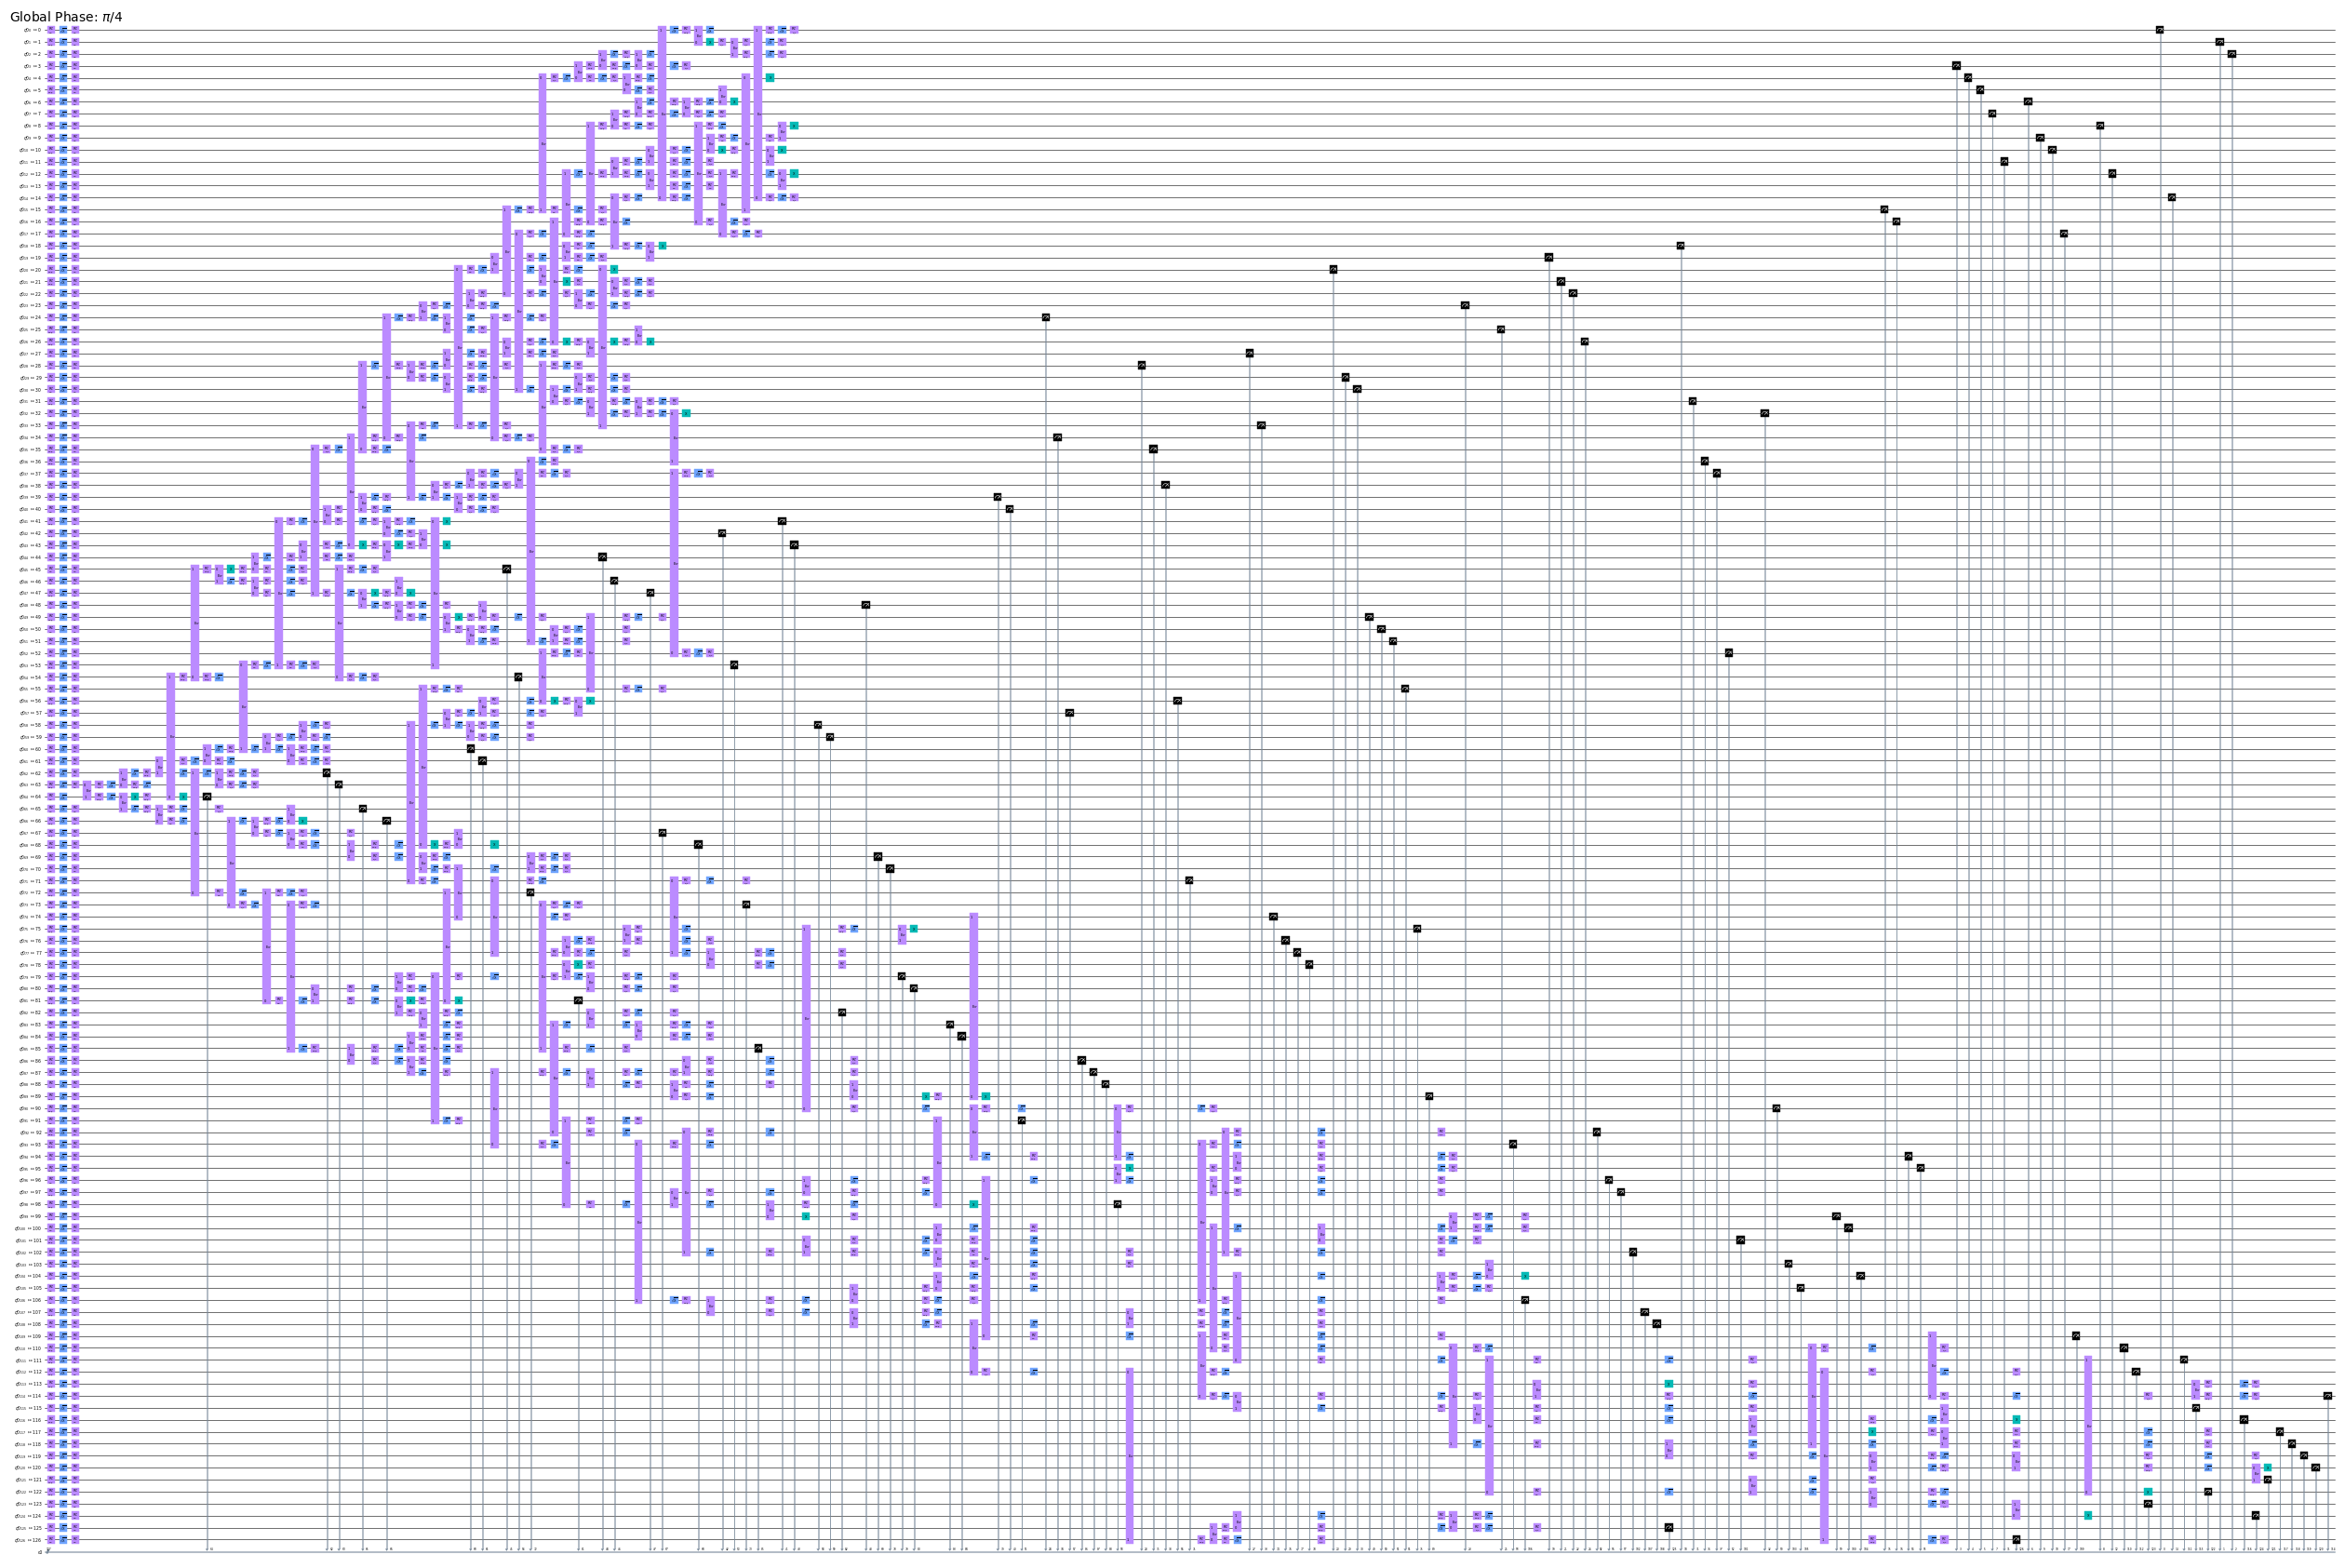

In [24]:
qc_transpiled.draw("mpl", scale=0.2, fold=200)

アダマールゲートとCXゲートが、他のゲートにトランスパイルされていることがわかります。IBMの量子デバイスはどれもアダマールゲートを直接サポートしていないので、アダマールゲートについては、驚くべきことではありません。アダマールゲートは常に3つの回転ゲートで構成されます。一方、ご覧のECRゲートは新しいもので、一部のデバイスでしか使われていません。これもCXゲートに似たエンタングルゲートですが、仕組みが少し違います。CXゲートは、ECRゲート１つとローカル回転ゲートだけで作ることができます。

ECRゲートの詳細については、こちらをご覧ください.
: https://qiskit.org/documentation/stable/0.39/stubs/qiskit.circuit.library.ECRGate.html 


Depthを減らすことは、エラー率を最小化するための最良の方法であることが多いです。ECRゲートが代わりに使われることがわかったところで、もっと良いDepthの回路を作ることはできないでしょうか？

その疑問や、GHZ状態をより良くするための他の方法を探ることに興味がある方は、どうぞ先をお読みください。このLabの次の部分は、ボーナス・パートです。この後にExerciseはありません。これは、エラー訂正をどのように使うことができるかを示すための短い展望であると同時に、エラー訂正がなぜ難しいかを示すためのものです。


続けるにしても、続けないにしても、自分に拍手を送ってあげてください： あなたは今、IBM Quantum Challenge: Spring 2023を完了したところです！Discordで他のみんなに自慢してください。Discordでお会いしましょう！

## ボーナス: エラー訂正への道

エラー訂正は、今でも活発で重要な研究テーマです。そのため、実機でのエラー訂正は、今回のGHZ状態の例のような単純なケースであっても、それほど簡単ではありません。このページでは、どのような方法が考えられるかについて、いくつかのガイダンスやヒントを提供しながら、独自のアイデアを生み出す機会を提供したいと思います。



### Step 1: 実際の状態はどの程度よかったのか？

エラーを修正する前に、まず状態がどの程度良かったかを知る必要がありますが、これさえも思ったほど簡単ではありません。

あなたのGHZ状態がどれだけ優れているかをテストする最も簡単な方法は、偶数量子ビットのうち、どれだけが多数派と異なる結果を得たかを調べることです。この方法は、上記で使用した方が多いのではないでしょうか？

しかし、これは必ずしもエラーの発生回数と相関があることを意味するものではありません。そして、GHZの良し悪しを知るには、エラーの発生数の方が重要であるとも言えます。


**例 A** : この考えを説明するために、例えば、10個の一列に並んだ量子ビットで、GHZ状態を形成するとします：

0 - 1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9

ここで、読み出しではなく、量子ビット4と量子ビット5の間でエンタングルゲートを適用したときにエラーが発生したとすると、出力は次のようになります：

0000011111 

これは、「何個の量子ビットが同じ結果を出すか」という測定において、最悪の結果となります。

このため、より多くのエラーが発生するようにすれば、「何個の量子ビットが同じ結果を持つか」をより正確に測定できる可能性がありますが、ほとんどの場合、その状態はあまり役に立たなくなります。

もし上記のような状態が作られ、量子ビットの間で(機能する)スタビライザー測定が行われていたとしたら、量子ビット4と5の間の測定値が1になるだけです。そして、このエラーを修正するために、量子ビット5-9を反転させることが可能です。

あなたのケースでエラーがどのように見えるかを知るには、実際のデバイスで実行した結果である生データを見て、GHZ状態をどのように構築したかを考慮するのが良いアイデアかもしれません。

**例A** の場合、次のようなエラー訂正が考えられます：

In [25]:
# 例 A の簡単なアイデア: エラーが発生した場所を見つけて、それに応じて反転する
def correct_ghz():
    qc = QuantumCircuit(quantum_register, classical_register)

    with qc.if_test((classical_register[9], 1)):
        qc.x(quantum_register[9])

    with qc.if_test((classical_register[8], 1)):
        qc.x(quantum_register[8])

    with qc.if_test((classical_register[8], 1)):
        qc.x(quantum_register[9])

    with qc.if_test((classical_register[7], 1)):
        qc.x(quantum_register[9])

    with qc.if_test((classical_register[7], 1)):
        qc.x(quantum_register[8])

    with qc.if_test((classical_register[7], 1)):
        qc.x(quantum_register[7])

    # ...

    # qc.barrier()
    return qc


correcting_circuit = correct_ghz()

そして、もし今、私たちが上記のコードを私たちの54GHZのケースに適応させるなら、すべてを一緒に構築することができます：

In [26]:
# Everything together corrected

error_corrected_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(correcting_circuit)
    .compose(measure_circuit)
)

### Step 2: なぜ単一のスタビライザーだけでは不十分なのか

エラー訂正のExerciseでは、スタビライザー量子ビットの測定から、1ビット、またはビット列全体を使用して、その演算を条件付けることができることを確認しました。

スタビライザー測定は54ビットなので、ビット列全体を条件付けに使うのは現実的ではありません。なぜなら、2^54個の異なるビット列を考慮する必要があるからです。

一方、1ビットだけを考慮する場合は、不可能であるか、または過度に複雑になる可能性があります。


**例**: 再び10個の量子ビットを一列に接続し、それらでGHZ状態を形成します：

0 - 1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9

ここで、測定結果として0000010000が得られたと仮定します。

この場合、スタビライザー測定では、1の右側と1の左側がともに値1になります。

つまり、この場合、1つのスタビライザーを見ただけでは、5番の量子ビットを反転させればよい（他の量子ビットは反転させない）ことを知るには不十分であることがわかります。ただし、いくつかの量子ビットを何度も反転させてもよいという場合はこの限りではありませんが、それは理想的ではありません。

そこで、この場合、スタビライザーの測定結果に関数を適用し、その結果を動的回路の条件として使用できれば理想的です。

これは可能ですが、QiskitではなくOpen QASM3のコードで行う必要があり、このExerciseでは取り上げません。
Open QASM3によるDynamic Circuitについてもっと知りたい場合は、ここで情報を得ることができます： 

https://quantum-computing.ibm.com/services/resources/docs/resources/manage/systems/dynamic-circuits/Dynamic-Circuits-basics-with-OpenQASM3

以下は、Open QASM3のコードの簡単な例です：

OPENQASM 3;
bit[2] c;
rz(-3.141592653589793) $0;
sx $0;
rz(-1.570796326794897) $1;
sx $1;
rz(-3.141592653589793) $1;
ecr $1, $0;
rz(-1.5707963267948966) $0;
sx $0;
rz(1.5707963267948966) $0;
rz(1.5707963267948966) $1;
sx $1;
rz(1.5707963267948966) $1;
c[0] = measure $0;
c[1] = measure $0;



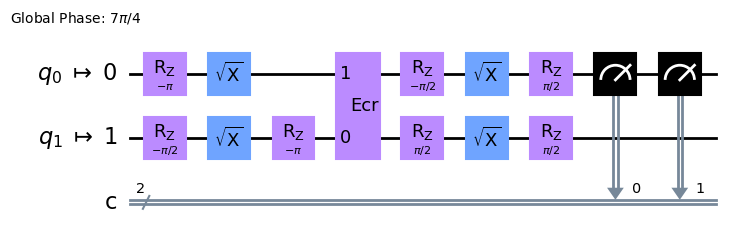

In [27]:
from qiskit import qasm3, QuantumCircuit, transpile

# ベル回路を作成します
qc_bell = QuantumCircuit(2, 2)
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure(0, 0)
qc_bell.measure(0, 1)

# デバイス用にトランスパイルします (上で述べたように、H ゲートと CX ゲートはありません)
qc_bell = transpile(qc_bell, backend)

# print前にqasm3コードを生成します
exporter = qasm3.Exporter(
    includes=[], disable_constants=True, basis_gates=backend.configuration().basis_gates
)
print(qasm3_bell := exporter.dumps(qc_bell))

# 比較のために回路を描いてみます
qc_bell.draw(output="mpl", idle_wires=False)

### Step 3: エラーを増やさないためにはどうするか？


エラーが発生する原因はさまざまです。時間経過によるデコヒーレンスや、CX-Gateのようなエンタングルゲートで発生するエラーは、そのうちの2つです。この2つはスタビライザーにも当てはまるので、本末転倒にならないように、エラーを修正しようとすることでノイズを増やさないようにする必要があります。将来的には、一般的なエラーレートがさらに下がるので、それほど問題にはならないかもしれませんが、それでも考慮しなければならないことです。

このことは、私たちにとってどのような意味を持つのでしょうか？

スタビライザーを作成し、測定したい時について考えてみましょう。次の量子ビットのエンタングルに使われなくなった後、直接エンタングルを解くのでしょうか？ 回路全体がエンタングルされるまで待つのでしょうか？(これはもちろん、どのような種類のエラーを修正したいかによります。）また、スタビライザーをリセットして、後で新しいものを作る（同じ量子ビットを使う）、エラーを修正するために2つのフェーズを使う、ということも考えられます。

そして、（スタビライザーを通して）量子ビットをエンタングルすることでエラーが発生する確率はどれくらいなのかを考え、スタビライザーをアンエンタングルすることでエラーが発生する確率と比較することができます。つまり、スタビライザーがあることで、かえって悪化しているのかも？

その価値はいつあるのでしょうか？以下のコードで遊んでみて、印象やアイデアを得ることができます。ただし、これは将来、エラーレートがさらに低下したときに変更される可能性があります。

In [29]:
# ここでのエラー確率はすべて、CXゲートによるエラーのみを考慮していて、またそれがビット・フリップ・エラーであると想定しています。

# 1つのCXゲートによるエラー確率
p1 = 0.01

# （スタビライザーを通る）2つのCXゲートの後にエラーが発生する確率
p2 = p1 * (1 - p1) + (1 - p1) * p1

# 正しい場合でも、スタビライザーが何かが間違っていることを示す確率
p3 = p1 * p1 + (1 - p1) * (1 - p1) * p1

print("CXゲート1つがエラーを持つ確率: {}".format(p1))
print("CXゲート2つの時にエラーが起こる確率: {:.4f}".format(p2))
print("スタビライザーが間違える確率: {:.4f}".format(p3))

CXゲート1つがエラーを持つ確率: 0.01
CXゲート2つの時にエラーが起こる確率: 0.0198
スタビライザーが間違える確率: 0.0099


### Step 4: 何ができるでしょうか？

あなたが試せる可能性はたくさんあります：



- 複数のスタビライザーを使って何か良い論理的な機能を見つけ、QASM3を使ってみるのも良いでしょう。

- スタビライザーをリセットして再利用することを考えることができます。

- 例Aのようなシンプルな方法をうまく使えないか試すことができます（測定するタイミングを変えるなど）。

- 自分自身のアイデアを見つけることができます！クリエイティブになりましょう！


いずれも重要なのは、やみくもに量子コンピュータで試すのではなく、最初のGHZ状態を走らせたデータを使って、まず自分の考えを検証してみることです。

上記でテストデータを作成しました： GHZ状態の出力と、スタビライザーの出力があります。

あなたのアプローチが後処理としてうまくいかないのであれば、実機で動作させれば、すべての演算にさらなるエラーレートが発生するため、うまくいかないでしょう。

手持ちのデータで理論的に動作するアルゴリズムができたら（テストによりGHZ状態が良くなったら）、以下のコードを使って、エラー訂正を含む回路全体を実機で動かしてみることができるようになります。

*ヒント：上記のerror_correction関数を使用し、上記のerror_corrected_ghzも生成することを確認してください。

In [ ]:
# 初めにGHZ状態を実際にデバイスにTranspileします
qc_corrected_transpiled = transpile(
    error_corrected_ghz, backend, initial_layout=initial_layout
)

# jobを実行します
job_corrected = backend.run(
    qc_corrected_transpiled,
    dynamic=True,
    shots=number_of_shots,
    memory=True,
    job_tags=["dynamic", "spring_challenge"],
)

job_id = job_corrected.job_id()
print(job_id)

In [ ]:
job_corrected = provider.retrieve_job(job_id)
job_corrected.status()

In [ ]:
# 結果を呼び戻します
counts_corrected = job_corrected.result().get_counts()